# 09e: Trade Flow Forecasting — NO_5 (Bergen)

**Phase 3** — Machine learning forecasting of net electricity exchange (MWh) for NO_5 (Bergen).

This notebook predicts **net electricity exchange** (positive = net export, negative = net import)
using gradient boosted tree models trained on fundamental features.

**Why trade flows matter for price formation:**
- Norway is heavily interconnected with Nordic and European markets via subsea cables and AC ties
- Net exchange direction signals whether Norway is a net exporter (surplus hydro) or importer (deficit)
- Export periods typically coincide with lower domestic prices (abundant supply)
- Import periods signal scarcity — higher domestic prices, influenced by continental gas/coal prices
- Forecasting trade flows helps anticipate price regime shifts and cross-border arbitrage opportunities

**Target:** `net_exchange_mwh` (from Statnett — daily net exchange, forward-filled to hourly)
- Positive values = net export from Norway
- Negative values = net import to Norway

**Note on NO_5 data:** NO_5 (Bergen/Western Norway) has aggregate `net_exchange_mwh` from Statnett.
It does NOT have per-cable flow columns (those are available for NO_2 which has NorNed, NordLink,
Skagerrak, and North Sea Link). NO_5's trade flows reflect internal Norwegian redistribution and
the aggregate national exchange position.

**Methods:**
1. Naive baseline (same hour last week)
2. XGBoost
3. LightGBM
4. CatBoost
5. Weighted ensemble (inverse-MAE)
6. Walk-forward validation (6-fold)
7. SHAP feature importance analysis
8. Yr weather forecast integration (forward-looking predictions)

**Data split:**
- Training: 2022-01-01 to 2024-12-31
- Validation: 2025-01-01 to 2025-06-30
- Cutoff: 2026-02-22

In [1]:
import sys
import logging
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

# Project imports
sys.path.insert(0, str(Path.cwd().parent))
from src.models.forecasters import NaiveForecaster
from src.models.train import (
    MLPriceForecaster,
    prepare_ml_features,
    walk_forward_validate,
    train_ensemble,
    forecast_with_yr,
)
from src.models.evaluate import compute_metrics, comparison_table, plot_forecast, plot_residuals

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(name)s %(levelname)s %(message)s")

%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 5)
plt.rcParams["figure.dpi"] = 100

ZONE = "NO_5"
TARGET_COL = "net_exchange_mwh"
print(f"Forecasting target: {TARGET_COL} for {ZONE} (Bergen)")
print(f"Positive = net export from Norway, Negative = net import")

Forecasting target: net_exchange_mwh for NO_5 (Bergen)
Positive = net export from Norway, Negative = net import


In [2]:
# Load feature matrix
data_path = Path.cwd().parent / "data" / "processed" / "features_NO_5_2022-01-01_2026-01-01.parquet"
df = pd.read_parquet(data_path)
print(f"Loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Verify target column exists
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)}"

# Extract target
target = df[TARGET_COL]

# Truncate at 2026-02-22 (end of available verified data)
cutoff = pd.Timestamp("2026-02-22", tz="Europe/Oslo")
df = df[df.index <= cutoff]
target = target[target.index <= cutoff]
print(f"After truncation: {len(target):,} hours ({target.index.min()} to {target.index.max()})")

# Data quality
print(f"\nData quality for {TARGET_COL}:")
print(f"  NaN count: {target.isna().sum()} ({target.isna().mean()*100:.1f}%)")
print(f"  Range: {target.min():,.0f} to {target.max():,.0f} MWh")
print(f"  Mean: {target.mean():,.0f} MWh")
print(f"  Std: {target.std():,.0f} MWh")

# Export vs import breakdown
valid_target = target.dropna()
n_export = (valid_target > 0).sum()
n_import = (valid_target < 0).sum()
n_zero = (valid_target == 0).sum()
print(f"\n  Export hours (positive): {n_export:,} ({n_export/len(valid_target)*100:.1f}%)")
print(f"  Import hours (negative): {n_import:,} ({n_import/len(valid_target)*100:.1f}%)")
print(f"  Zero/balanced hours:     {n_zero:,} ({n_zero/len(valid_target)*100:.1f}%)")

# Yearly summary
print(f"\nYearly summary:")
for year in range(2022, 2026):
    mask = target.index.year == year
    yearly = target[mask].dropna()
    if len(yearly) == 0:
        continue
    pct_export = (yearly > 0).mean() * 100
    print(f"  {year}: {len(yearly):>6,} hours, mean={yearly.mean():>8,.0f} MWh, "
          f"export={pct_export:.0f}%, min={yearly.min():>10,.0f}, max={yearly.max():>10,.0f}")

Loaded: 35,065 rows x 63 columns
Date range: 2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00
After truncation: 35,065 hours (2022-01-01 00:00:00+01:00 to 2026-01-01 00:00:00+01:00)

Data quality for net_exchange_mwh:
  NaN count: 0 (0.0%)
  Range: -116,060 to 124,469 MWh
  Mean: 54,318 MWh
  Std: 43,303 MWh

  Export hours (positive): 30,792 (87.8%)
  Import hours (negative): 4,273 (12.2%)
  Zero/balanced hours:     0 (0.0%)

Yearly summary:
  2022:  8,760 hours, mean=  28,346 MWh, export=75%, min=   -81,771, max=   113,138
  2023:  8,760 hours, mean=  50,527 MWh, export=86%, min=  -116,060, max=   117,394
  2024:  8,784 hours, mean=  68,574 MWh, export=93%, min=   -81,374, max=   121,666
  2025:  8,760 hours, mean=  69,799 MWh, export=97%, min=   -45,894, max=   124,469


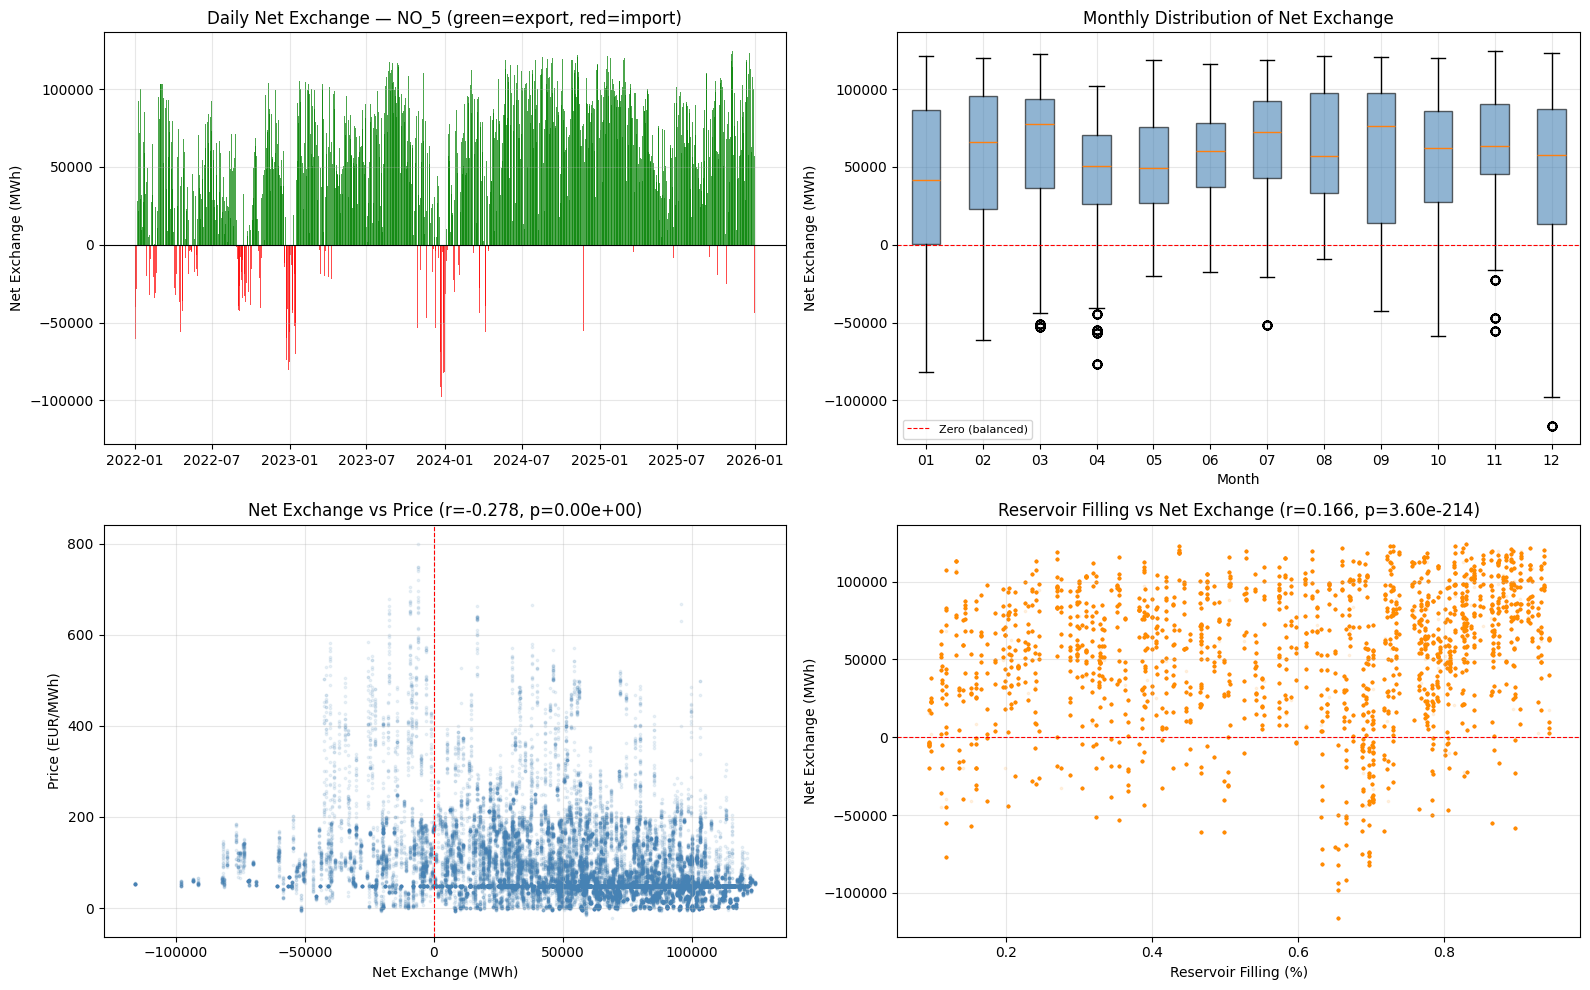

In [3]:
# EDA: net exchange overview
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Panel 1: Time series ---
ax = axes[0, 0]
daily_exchange = target.resample("D").mean().dropna()
colors_ts = ["green" if v > 0 else "red" for v in daily_exchange.values]
ax.bar(daily_exchange.index, daily_exchange.values, width=1.5, color=colors_ts, alpha=0.7)
ax.axhline(y=0, color="black", linewidth=0.8)
ax.set_ylabel("Net Exchange (MWh)")
ax.set_title(f"Daily Net Exchange — {ZONE} (green=export, red=import)")
ax.grid(True, alpha=0.3)

# --- Panel 2: Monthly boxplot ---
ax = axes[0, 1]
monthly_data = []
month_labels = []
for m in range(1, 13):
    monthly = target[target.index.month == m].dropna()
    if len(monthly) > 0:
        monthly_data.append(monthly.values)
        month_labels.append(f"{m:02d}")
bp = ax.boxplot(monthly_data, labels=month_labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.6)
ax.axhline(y=0, color="red", linestyle="--", linewidth=0.8, label="Zero (balanced)")
ax.set_xlabel("Month")
ax.set_ylabel("Net Exchange (MWh)")
ax.set_title("Monthly Distribution of Net Exchange")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 3: Correlation with price ---
ax = axes[1, 0]
if "price_eur_mwh" in df.columns:
    scatter_df = df[[TARGET_COL, "price_eur_mwh"]].dropna()
    ax.scatter(scatter_df[TARGET_COL], scatter_df["price_eur_mwh"],
               alpha=0.1, s=3, color="steelblue")
    # Add correlation
    r, p = stats.pearsonr(scatter_df[TARGET_COL], scatter_df["price_eur_mwh"])
    ax.set_xlabel("Net Exchange (MWh)")
    ax.set_ylabel("Price (EUR/MWh)")
    ax.set_title(f"Net Exchange vs Price (r={r:.3f}, p={p:.2e})")
    ax.axvline(x=0, color="red", linestyle="--", linewidth=0.8)
else:
    ax.text(0.5, 0.5, "No price data", ha="center", va="center", transform=ax.transAxes)
ax.grid(True, alpha=0.3)

# --- Panel 4: Correlation with reservoir filling ---
ax = axes[1, 1]
if "reservoir_filling_pct" in df.columns:
    scatter_df2 = df[[TARGET_COL, "reservoir_filling_pct"]].dropna()
    ax.scatter(scatter_df2["reservoir_filling_pct"], scatter_df2[TARGET_COL],
               alpha=0.1, s=3, color="darkorange")
    r2, p2 = stats.pearsonr(scatter_df2["reservoir_filling_pct"], scatter_df2[TARGET_COL])
    ax.set_xlabel("Reservoir Filling (%)")
    ax.set_ylabel("Net Exchange (MWh)")
    ax.set_title(f"Reservoir Filling vs Net Exchange (r={r2:.3f}, p={p2:.2e})")
    ax.axhline(y=0, color="red", linestyle="--", linewidth=0.8)
else:
    ax.text(0.5, 0.5, "No reservoir data", ha="center", va="center", transform=ax.transAxes)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Train / Validation split
TRAIN_END = pd.Timestamp("2024-12-31 23:00", tz="Europe/Oslo")
VAL_END = pd.Timestamp("2025-06-30 23:00", tz="Europe/Oslo")

y_train = target[target.index <= TRAIN_END]
y_val = target[(target.index > TRAIN_END) & (target.index <= VAL_END)]
y_test = target[target.index > VAL_END]

# Also split the full DataFrame for features
df_train = df[df.index <= TRAIN_END]
df_val = df[(df.index > TRAIN_END) & (df.index <= VAL_END)]
df_test = df[df.index > VAL_END]

print(f"Training:   {len(y_train):>6,} hours  ({y_train.index.min().date()} to {y_train.index.max().date()})")
print(f"Validation: {len(y_val):>6,} hours  ({y_val.index.min().date()} to {y_val.index.max().date()})")
print(f"Test:       {len(y_test):>6,} hours  ({y_test.index.min().date()} to {y_test.index.max().date()})")

print(f"\nTrain: mean={y_train.mean():>8,.0f} MWh, std={y_train.std():>8,.0f}, export={((y_train>0).mean()*100):.0f}%")
print(f"Val:   mean={y_val.mean():>8,.0f} MWh, std={y_val.std():>8,.0f}, export={((y_val>0).mean()*100):.0f}%")
print(f"Test:  mean={y_test.mean():>8,.0f} MWh, std={y_test.std():>8,.0f}, export={((y_test>0).mean()*100):.0f}%")

Training:   26,304 hours  (2022-01-01 to 2024-12-31)
Validation:  4,343 hours  (2025-01-01 to 2025-06-30)
Test:        4,418 hours  (2025-07-01 to 2026-01-01)

Train: mean=  49,167 MWh, std=  45,326, export=85%
Val:   mean=  69,110 MWh, std=  32,766, export=97%
Test:  mean=  70,452 MWh, std=  31,025, export=97%


## 2. Feature Preparation

**Leakage prevention:** We must drop `net_balance_mwh` because it is derived from the
combination of net exchange + production + consumption. Including it would leak the target.

We **keep** `production_mwh` and `consumption_mwh` as features because they are independent
measurements that *drive* trade flows (surplus production leads to exports, deficit leads
to imports). These are the fundamental supply/demand drivers we want the model to learn from.

In [5]:
# Prepare features with leakage prevention
# Drop net_balance_mwh (derived from exchange + production + consumption)
LEAKAGE_COLS = ["net_balance_mwh"]

X_train_full, y_train_full = prepare_ml_features(
    df_train, target_col=TARGET_COL, drop_cols=LEAKAGE_COLS,
)
X_val_full, y_val_full = prepare_ml_features(
    df_val, target_col=TARGET_COL, drop_cols=LEAKAGE_COLS,
)

print(f"Feature matrix: {X_train_full.shape[1]} features")
print(f"Training: {len(X_train_full):,} samples")
print(f"Validation: {len(X_val_full):,} samples")

# Group features by category
categories = {
    "Calendar": [c for c in X_train_full.columns if c in [
        "hour_of_day", "day_of_week", "month", "week_of_year",
        "is_weekend", "is_holiday", "is_business_hour"]],
    "Price": [c for c in X_train_full.columns if "price" in c],
    "Weather": [c for c in X_train_full.columns if c in [
        "temperature", "wind_speed", "precipitation",
        "temperature_lag_24h", "temperature_rolling_24h_mean"]],
    "Commodities": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["ttf_", "brent_", "coal_", "ng_"])],
    "Reservoir": [c for c in X_train_full.columns if "reservoir" in c],
    "FX": [c for c in X_train_full.columns if c == "eur_nok"],
    "ENTSO-E": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["actual_", "load_", "generation_",
                                   "hydro_", "wind_share", "total_net",
                                   "n_cables"])],
    "Internal Flows": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["flow_from_", "total_internal_",
                                   "net_internal_"])],
    "Statnett": [c for c in X_train_full.columns if any(
        c.startswith(p) for p in ["production_", "consumption_"])],
}

# Catch uncategorized
all_categorized = set()
for cols in categories.values():
    all_categorized.update(cols)
uncategorized = [c for c in X_train_full.columns if c not in all_categorized]
if uncategorized:
    categories["Other"] = uncategorized

print(f"\nFeatures by category:")
for cat, cols in categories.items():
    if cols:
        print(f"  {cat} ({len(cols)}): {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

# Confirm leakage columns are dropped
for col in LEAKAGE_COLS + [TARGET_COL]:
    assert col not in X_train_full.columns, f"LEAKAGE: {col} is still in features!"
print(f"\nLeakage check passed: {LEAKAGE_COLS} and {TARGET_COL} not in features.")
print(f"Kept as features: production_mwh={'production_mwh' in X_train_full.columns}, "
      f"consumption_mwh={'consumption_mwh' in X_train_full.columns}")

2026-02-24 22:46:03,190 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:46:03,196 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:46:03,199 src.models.train INFO Prepared 26304 samples with 35 features (target: net_exchange_mwh)
2026-02-24 22:46:03,200 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:46:03,201 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:46:03,202 src.models.train INFO Prepared 4343 samples with 35 features (target: net_exchange_mwh)


Feature matrix: 35 features
Training: 26,304 samples
Validation: 4,343 samples

Features by category:
  Calendar (7): hour_of_day, day_of_week, month, week_of_year, is_weekend...
  Price (1): price_eur_mwh
  Weather (5): temperature, wind_speed, precipitation, temperature_lag_24h, temperature_rolling_24h_mean
  Commodities (5): ttf_gas_close, brent_oil_close, coal_close, ng_fut_close, ttf_gas_change_7d
  Reservoir (5): reservoir_filling_pct, reservoir_filling_twh, reservoir_filling_change, reservoir_vs_median, reservoir_vs_min
  FX (1): eur_nok
  ENTSO-E (9): actual_load, load_lag_24h, load_lag_168h, load_rolling_24h_mean, generation_hydro...
  Statnett (2): production_mwh, consumption_mwh

Leakage check passed: ['net_balance_mwh'] and net_exchange_mwh not in features.
Kept as features: production_mwh=True, consumption_mwh=True


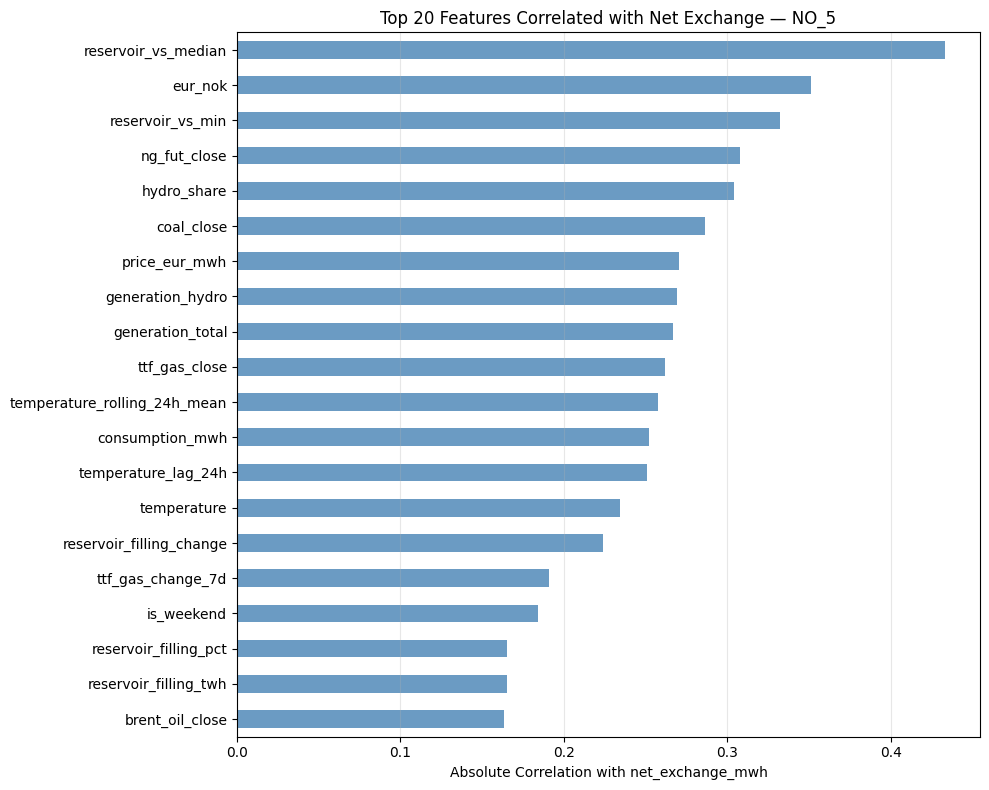

Top 10 correlated features:
  reservoir_vs_median: |r|=0.433 (+0.433)
  eur_nok: |r|=0.351 (+0.351)
  reservoir_vs_min: |r|=0.332 (+0.332)
  ng_fut_close: |r|=0.308 (-0.308)
  hydro_share: |r|=0.304 (+0.304)
  coal_close: |r|=0.286 (-0.286)
  price_eur_mwh: |r|=0.270 (-0.270)
  generation_hydro: |r|=0.270 (+0.270)
  generation_total: |r|=0.267 (+0.267)
  ttf_gas_close: |r|=0.262 (-0.262)


In [6]:
# Correlation with target: top 20 features
corr_with_target = X_train_full.corrwith(y_train_full).abs().sort_values(ascending=False)
top_corr = corr_with_target.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
top_corr.plot(kind="barh", ax=ax, color="steelblue", alpha=0.8)
ax.set_xlabel(f"Absolute Correlation with {TARGET_COL}")
ax.set_title(f"Top 20 Features Correlated with Net Exchange — {ZONE}")
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("Top 10 correlated features:")
for feat, corr in top_corr.head(10).items():
    # Show direction (positive or negative correlation)
    raw_corr = X_train_full[feat].corr(y_train_full)
    direction = "+" if raw_corr > 0 else "-"
    print(f"  {feat}: |r|={corr:.3f} ({direction}{abs(raw_corr):.3f})")

## 3. Naive Baseline

The simplest possible forecast: predict that each hour's net exchange equals the same hour
from last week. Since the underlying Statnett data is daily resolution (forward-filled to hourly),
this effectively predicts "same day last week's exchange value".

**Every model below must beat this.** A model that cannot beat `shift(168)` is adding
complexity without value.

In [7]:
# Collect results for all methods
all_results = []
all_forecasts = {}

# Naive baseline: same hour last week (lag=168)
naive = NaiveForecaster(
    name="Naive (same hour last week)",
    horizon=len(y_val),
    frequency="h",
    lag=168,
)
naive.fit(y_train)
naive_pred = naive.predict(steps=len(y_val))
naive_pred.index = y_val.index

naive_metrics = compute_metrics(y_val, naive_pred)
all_results.append({"name": "Naive (same hour last week)", "metrics": naive_metrics, "fit_time": naive.fit_time_seconds})
all_forecasts["Naive"] = naive_pred

print("Naive Baseline Results:")
for k, v in naive_metrics.items():
    print(f"  {k}: {v}")

# Context: how big are the errors relative to the target?
print(f"\nContext:")
print(f"  Target range: {y_val.min():,.0f} to {y_val.max():,.0f} MWh")
print(f"  Target std: {y_val.std():,.0f} MWh")
print(f"  Naive MAE / Target std: {naive_metrics['mae'] / y_val.std():.2f}")

2026-02-24 22:46:03,297 src.models.forecasters INFO Naive (same hour last week) fit complete: 26304 samples in 0.0 seconds


Naive Baseline Results:
  mae: 37961.362
  rmse: 48125.333
  mape: 154.61
  directional_accuracy: 2.1
  peak_hour_mae: 37956.721

Context:
  Target range: -45,894 to 122,762 MWh
  Target std: 32,766 MWh
  Naive MAE / Target std: 1.16


## 4. ML Models

We train three gradient boosted tree models on the full fundamental feature set.
These models can capture nonlinear relationships between production, consumption,
reservoir levels, weather, commodities, and trade flows.

**Key expectations:**
- `production_mwh` and `consumption_mwh` should be top features (supply-demand balance drives trade)
- Reservoir levels may matter (high reservoirs = more hydro export capacity)
- Price features may correlate (high prices = import regime)
- Seasonal patterns (summer vs winter demand) affect trade direction

In [8]:
%%time

# XGBoost
xgb_model = MLPriceForecaster("xgboost")
xgb_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
xgb_pred = xgb_model.predict(X_val_full)

xgb_metrics = compute_metrics(y_val_full, xgb_pred, naive_pred=naive_pred)
all_results.append({"name": "XGBoost", "metrics": xgb_metrics, "fit_time": xgb_model.fit_time_seconds})
all_forecasts["XGBoost"] = xgb_pred

print(f"XGBoost Results:")
for k, v in xgb_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {xgb_model.fit_time_seconds:.1f}s")
print(f"  vs Naive: {'BETTER' if xgb_metrics['mae'] < naive_metrics['mae'] else 'WORSE'} "
      f"(skill_score: {xgb_metrics.get('skill_score', 'N/A')})")

2026-02-24 22:46:03,685 src.models.train INFO xgboost fit: 26304 samples, 35 features in 0.1 s


XGBoost Results:
  mae: 33767.93
  rmse: 39982.64
  mape: 85.61
  directional_accuracy: 0.1
  peak_hour_mae: 33769.085
  skill_score: 0.11

  Fit time: 0.1s
  vs Naive: BETTER (skill_score: 0.11)
CPU times: user 444 ms, sys: 208 ms, total: 652 ms
Wall time: 351 ms


In [9]:
%%time

# LightGBM
lgbm_model = MLPriceForecaster("lightgbm")
lgbm_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
lgbm_pred = lgbm_model.predict(X_val_full)

lgbm_metrics = compute_metrics(y_val_full, lgbm_pred, naive_pred=naive_pred)
all_results.append({"name": "LightGBM", "metrics": lgbm_metrics, "fit_time": lgbm_model.fit_time_seconds})
all_forecasts["LightGBM"] = lgbm_pred

print(f"LightGBM Results:")
for k, v in lgbm_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {lgbm_model.fit_time_seconds:.1f}s")
print(f"  vs XGBoost: {'BETTER' if lgbm_metrics['mae'] < xgb_metrics['mae'] else 'WORSE or EQUAL'} "
      f"({lgbm_model.fit_time_seconds:.1f}s vs {xgb_model.fit_time_seconds:.1f}s)")

2026-02-24 22:46:04,347 src.models.train INFO lightgbm fit: 26304 samples, 35 features in 0.6 s, best_iteration=2


LightGBM Results:
  mae: 33307.468
  rmse: 39446.273
  mape: 83.92
  directional_accuracy: 0.5
  peak_hour_mae: 33341.762
  skill_score: 0.123

  Fit time: 0.6s
  vs XGBoost: BETTER (0.6s vs 0.1s)
CPU times: user 561 ms, sys: 1.28 s, total: 1.84 s
Wall time: 658 ms


In [10]:
%%time

# CatBoost
cat_model = MLPriceForecaster("catboost")
cat_model.fit(X_train_full, y_train_full, X_val_full, y_val_full)
cat_pred = cat_model.predict(X_val_full)

cat_metrics = compute_metrics(y_val_full, cat_pred, naive_pred=naive_pred)
all_results.append({"name": "CatBoost", "metrics": cat_metrics, "fit_time": cat_model.fit_time_seconds})
all_forecasts["CatBoost"] = cat_pred

print(f"CatBoost Results:")
for k, v in cat_metrics.items():
    print(f"  {k}: {v}")
print(f"\n  Fit time: {cat_model.fit_time_seconds:.1f}s")

# Quick comparison
print(f"\nML model comparison (MAE MWh):")
print(f"  XGBoost:  {xgb_metrics['mae']:,.1f}")
print(f"  LightGBM: {lgbm_metrics['mae']:,.1f}")
print(f"  CatBoost: {cat_metrics['mae']:,.1f}")
print(f"  Naive:    {naive_metrics['mae']:,.1f}")

2026-02-24 22:46:04,624 src.models.train INFO catboost fit: 26304 samples, 35 features in 0.2 s, best_iteration=10


CatBoost Results:
  mae: 31830.79
  rmse: 37892.805
  mape: 86.08
  directional_accuracy: 1.0
  peak_hour_mae: 31724.857
  skill_score: 0.161

  Fit time: 0.2s

ML model comparison (MAE MWh):
  XGBoost:  33,767.9
  LightGBM: 33,307.5
  CatBoost: 31,830.8
  Naive:    37,961.4
CPU times: user 1.03 s, sys: 233 ms, total: 1.26 s
Wall time: 270 ms


In [11]:
# Ensemble: inverse-MAE weighted average
model_maes = {
    "xgboost": xgb_metrics["mae"],
    "lightgbm": lgbm_metrics["mae"],
    "catboost": cat_metrics["mae"],
}
inv_maes = {k: 1.0 / v for k, v in model_maes.items()}
total_inv = sum(inv_maes.values())
weights = {k: v / total_inv for k, v in inv_maes.items()}

print("Ensemble weights (inverse-MAE):")
for k, w in weights.items():
    print(f"  {k}: {w:.3f} (MAE: {model_maes[k]:,.1f})")

# Weighted ensemble
ensemble_pred = (
    weights["xgboost"] * xgb_pred
    + weights["lightgbm"] * lgbm_pred
    + weights["catboost"] * cat_pred
)
ensemble_pred.name = "Ensemble (weighted)"

ens_metrics = compute_metrics(y_val_full, ensemble_pred, naive_pred=naive_pred)
all_results.append({"name": "Ensemble (weighted)", "metrics": ens_metrics, "fit_time": 0})
all_forecasts["Ensemble"] = ensemble_pred

# Grand comparison table
comp = comparison_table(all_results)
print(f"\n{'='*80}")
print(f"GRAND COMPARISON — Net Exchange Forecasting — {ZONE}")
print(f"Val period: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"{'='*80}")
display(comp)

# Highlight winner
best_method = comp.iloc[0]['Method']
best_mae = comp.iloc[0]['mae']
print(f"\nBest model: {best_method} (MAE={best_mae:,.1f} MWh)")
if best_mae < naive_metrics['mae']:
    improvement = (1 - best_mae / naive_metrics['mae']) * 100
    print(f"  {improvement:.1f}% better than naive baseline")

Ensemble weights (inverse-MAE):
  xgboost: 0.325 (MAE: 33,767.9)
  lightgbm: 0.330 (MAE: 33,307.5)
  catboost: 0.345 (MAE: 31,830.8)

GRAND COMPARISON — Net Exchange Forecasting — NO_5
Val period: 2025-01-01 to 2025-06-30


,Method,mae,rmse,mape,directional_accuracy,peak_hour_mae,fit_time_s,skill_score
Rank,,,,,,,,
1,CatBoost,31830.790,37892.805,86.08,1.0,31724.857,0.2,0.161
2,Ensemble (weighted),32741.111,38964.555,84.82,0.9,32758.804,0.0,0.138
3,LightGBM,33307.468,39446.273,83.92,0.5,33341.762,0.6,0.123
4,XGBoost,33767.930,39982.640,85.61,0.1,33769.085,0.1,0.110
5,Naive (same hour last week),37961.362,48125.333,154.61,2.1,37956.721,0.0,NaN



Best model: CatBoost (MAE=31,830.8 MWh)
  16.1% better than naive baseline


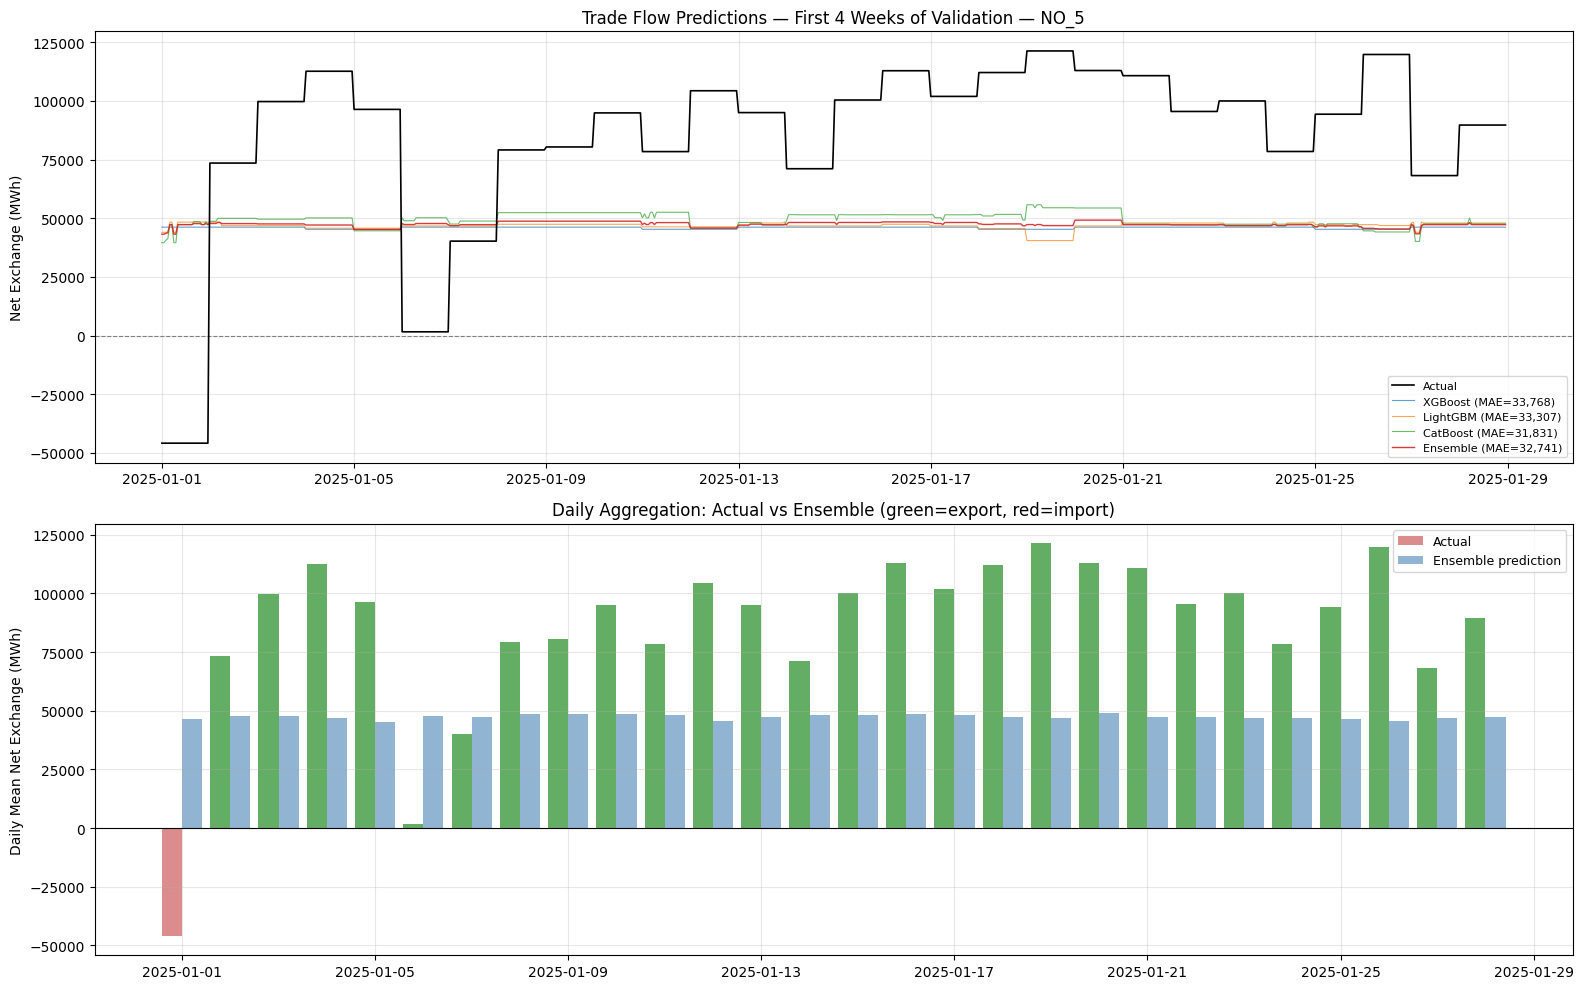

In [12]:
# Forecast overlay: 4 weeks of validation
# Trade flows are daily resolution (forward-filled to hourly), so show daily aggregates
four_weeks = y_val_full.index[:672]  # 4 weeks * 7 days * 24 hours

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# --- Panel 1: Hourly overlay ---
ax = axes[0]
ax.plot(y_val_full.loc[four_weeks].index, y_val_full.loc[four_weeks],
        color="black", linewidth=1.2, label="Actual", zorder=5)
ax.plot(xgb_pred.loc[four_weeks].index, xgb_pred.loc[four_weeks],
        color="tab:blue", linewidth=0.8, alpha=0.7, label=f"XGBoost (MAE={xgb_metrics['mae']:,.0f})")
ax.plot(lgbm_pred.loc[four_weeks].index, lgbm_pred.loc[four_weeks],
        color="tab:orange", linewidth=0.8, alpha=0.7, label=f"LightGBM (MAE={lgbm_metrics['mae']:,.0f})")
ax.plot(cat_pred.loc[four_weeks].index, cat_pred.loc[four_weeks],
        color="tab:green", linewidth=0.8, alpha=0.7, label=f"CatBoost (MAE={cat_metrics['mae']:,.0f})")
ax.plot(ensemble_pred.loc[four_weeks].index, ensemble_pred.loc[four_weeks],
        color="tab:red", linewidth=1.0, alpha=0.9, label=f"Ensemble (MAE={ens_metrics['mae']:,.0f})")
ax.axhline(y=0, color="gray", linestyle="--", linewidth=0.8)
ax.set_ylabel("Net Exchange (MWh)")
ax.set_title(f"Trade Flow Predictions — First 4 Weeks of Validation — {ZONE}")
ax.legend(loc="best", fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Daily bars (actual vs ensemble) ---
ax = axes[1]
daily_actual = y_val_full.loc[four_weeks].resample("D").mean().dropna()
daily_ensemble = ensemble_pred.loc[four_weeks].resample("D").mean().dropna()
# Align
common_idx = daily_actual.index.intersection(daily_ensemble.index)
bar_width = pd.Timedelta(hours=10)

actual_colors = ["forestgreen" if v > 0 else "indianred" for v in daily_actual.loc[common_idx].values]
ax.bar(common_idx - bar_width/2, daily_actual.loc[common_idx],
       width=bar_width, color=actual_colors, alpha=0.7, label="Actual")
ax.bar(common_idx + bar_width/2, daily_ensemble.loc[common_idx],
       width=bar_width, color="steelblue", alpha=0.6, label="Ensemble prediction")
ax.axhline(y=0, color="black", linewidth=0.8)
ax.set_ylabel("Daily Mean Net Exchange (MWh)")
ax.set_title("Daily Aggregation: Actual vs Ensemble (green=export, red=import)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Walk-Forward Validation

A single train/val split can be misleading. Walk-forward validation simulates real deployment:
the model always predicts unseen future data with an expanding training window.

```
Fold 1: Train [2022-01 -> 2025-01] | Val [2025-01 -> 2025-02]
Fold 2: Train [2022-01 -> 2025-02] | Val [2025-02 -> 2025-03]
Fold 3: Train [2022-01 -> 2025-03] | Val [2025-03 -> 2025-04]
...expanding window, always predicting unseen future data
```

This tells us: **is the model consistently good, or did we get lucky with one split?**

2026-02-24 22:46:04,929 src.models.train INFO Dropped 18 NOK columns (redundant with EUR)
2026-02-24 22:46:04,932 src.models.train INFO Dropped 8 price lag columns (learning fundamentals, not shortcuts): ['price_lag_1h', 'price_lag_24h', 'price_lag_168h', 'price_rolling_24h_mean', 'price_rolling_24h_std', 'price_rolling_168h_mean', 'price_diff_24h', 'price_diff_168h']
2026-02-24 22:46:04,932 src.models.train INFO Prepared 30647 samples with 36 features (target: net_exchange_mwh)
2026-02-24 22:46:05,070 src.models.train INFO catboost fit: 26327 samples, 36 features in 0.1 s
2026-02-24 22:46:05,076 src.models.train INFO Fold 1/6: train=26327, val=720, MAE=47228.98, fit=0.1s


Walk-forward validation using: catboost
Data: 30,647 hours
Configuration: 6 folds, ~720 hours (~1 month) each



2026-02-24 22:46:05,593 src.models.train INFO catboost fit: 27047 samples, 36 features in 0.5 s, best_iteration=145
2026-02-24 22:46:05,598 src.models.train INFO Fold 2/6: train=27047, val=720, MAE=22880.88, fit=0.5s
2026-02-24 22:46:05,877 src.models.train INFO catboost fit: 27767 samples, 36 features in 0.3 s, best_iteration=42
2026-02-24 22:46:05,882 src.models.train INFO Fold 3/6: train=27767, val=720, MAE=14178.40, fit=0.3s
2026-02-24 22:46:06,064 src.models.train INFO catboost fit: 28487 samples, 36 features in 0.2 s, best_iteration=13
2026-02-24 22:46:06,068 src.models.train INFO Fold 4/6: train=28487, val=720, MAE=16783.47, fit=0.2s
2026-02-24 22:46:06,188 src.models.train INFO catboost fit: 29207 samples, 36 features in 0.1 s
2026-02-24 22:46:06,192 src.models.train INFO Fold 5/6: train=29207, val=720, MAE=17874.99, fit=0.1s
2026-02-24 22:46:06,408 src.models.train INFO catboost fit: 29927 samples, 36 features in 0.2 s, best_iteration=30
2026-02-24 22:46:06,414 src.models.trai

,Fold,Train Size,Val Period,MAE,RMSE,Skill Score,Dir. Acc.,Fit Time (s)
0,1,"26,327",2025-01-01 -> 2025-01-31,47228.978,49896.360,-0.746,0.1,0.13
1,2,"27,047",2025-01-31 -> 2025-03-02,22880.875,28639.587,-0.408,2.1,0.51
2,3,"27,767",2025-03-02 -> 2025-04-01,14178.399,20466.590,0.536,2.2,0.27
3,4,"28,487",2025-04-02 -> 2025-05-01,16783.465,19016.318,0.345,0.8,0.18
4,5,"29,207",2025-05-02 -> 2025-05-31,17874.986,23363.953,0.082,0.3,0.12
5,6,"29,927",2025-06-01 -> 2025-06-30,22022.657,28066.491,0.350,1.3,0.21



Walk-forward MAE summary:
  Mean: 23,494.9 MWh
  Std:  11,024.8 MWh
  Min:  14,178.4 (best fold)
  Max:  47,229.0 (worst fold)


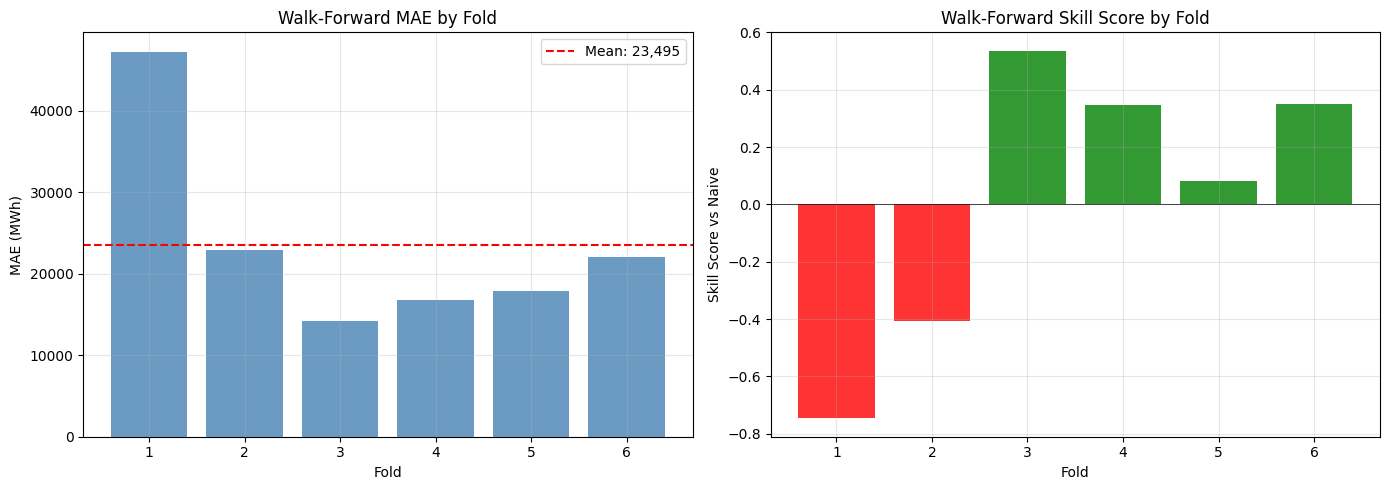

CPU times: user 9.28 s, sys: 1.85 s, total: 11.1 s
Wall time: 1.58 s


In [13]:
%%time

# Walk-forward validation with expanding window
df_walkforward = pd.concat([df_train, df_val])

# Use the best-performing individual model type
best_model_type = min(model_maes, key=model_maes.get)
print(f"Walk-forward validation using: {best_model_type}")
print(f"Data: {len(df_walkforward):,} hours")
print(f"Configuration: 6 folds, ~720 hours (~1 month) each\n")

wf_results = walk_forward_validate(
    df_walkforward,
    model_type=best_model_type,
    n_splits=6,
    val_size_hours=720,
    target_col=TARGET_COL,
)

# Display per-fold metrics
wf_rows = []
for r in wf_results:
    row = {
        "Fold": r["fold"],
        "Train Size": f"{r['train_size']:,}",
        "Val Period": f"{r['val_start'].strftime('%Y-%m-%d')} -> {r['val_end'].strftime('%Y-%m-%d')}",
        "MAE": r["metrics"].get("mae", np.nan),
        "RMSE": r["metrics"].get("rmse", np.nan),
        "Skill Score": r["metrics"].get("skill_score", np.nan),
        "Dir. Acc.": r["metrics"].get("directional_accuracy", np.nan),
        "Fit Time (s)": r["fit_time"],
    }
    wf_rows.append(row)

wf_df = pd.DataFrame(wf_rows)
display(wf_df)

# Summary statistics
mae_values = [r["metrics"]["mae"] for r in wf_results if "mae" in r["metrics"]]
print(f"\nWalk-forward MAE summary:")
print(f"  Mean: {np.mean(mae_values):,.1f} MWh")
print(f"  Std:  {np.std(mae_values):,.1f} MWh")
print(f"  Min:  {np.min(mae_values):,.1f} (best fold)")
print(f"  Max:  {np.max(mae_values):,.1f} (worst fold)")

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MAE per fold
ax = axes[0]
folds = [r["fold"] for r in wf_results]
maes = [r["metrics"]["mae"] for r in wf_results]
ax.bar(folds, maes, color="steelblue", alpha=0.8)
ax.axhline(np.mean(maes), color="red", linestyle="--", label=f"Mean: {np.mean(maes):,.0f}")
ax.set_xlabel("Fold")
ax.set_ylabel("MAE (MWh)")
ax.set_title("Walk-Forward MAE by Fold")
ax.legend()
ax.grid(True, alpha=0.3)

# Skill score per fold
ax = axes[1]
skills = [r["metrics"].get("skill_score", 0) for r in wf_results]
colors_sk = ["green" if s > 0 else "red" for s in skills]
ax.bar(folds, skills, color=colors_sk, alpha=0.8)
ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
ax.set_xlabel("Fold")
ax.set_ylabel("Skill Score vs Naive")
ax.set_title("Walk-Forward Skill Score by Fold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. SHAP Analysis

**SHAP (SHapley Additive exPlanations)** reveals how each feature contributes to
individual predictions. For trade flow forecasting, we expect:
- **Production/consumption** to dominate (supply-demand balance is the primary driver)
- **Price features** to matter (high prices signal scarcity and import need)
- **Reservoir levels** to influence (high reservoirs = more export capacity)
- **Weather** to contribute via its effect on production (wind, temperature) and demand
- **Calendar features** to capture seasonal trade patterns (winter imports vs summer exports)

Computing SHAP values for XGBoost model...
Using up to 2000 validation samples

SHAP values computed: (2000, 35)
Base value (expected prediction): 49,172 MWh


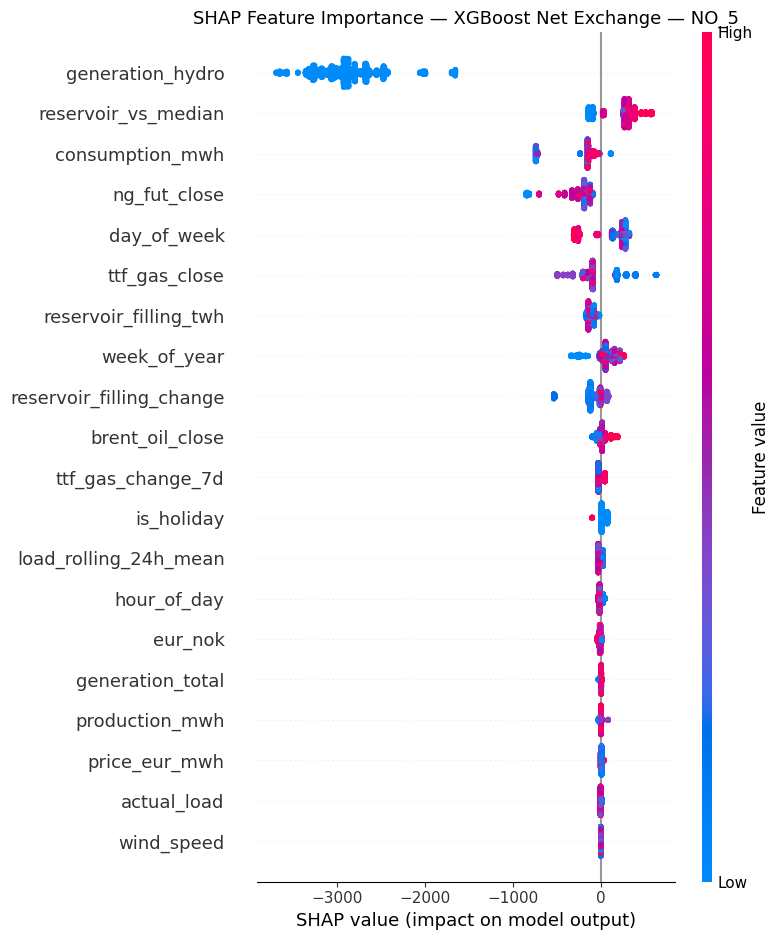


Top 10 features by mean |SHAP value|:
  1. generation_hydro: 2,902.0 MWh
  2. reservoir_vs_median: 278.6 MWh
  3. consumption_mwh: 264.7 MWh
  4. ng_fut_close: 234.2 MWh
  5. day_of_week: 233.7 MWh
  6. ttf_gas_close: 176.8 MWh
  7. reservoir_filling_twh: 108.3 MWh
  8. week_of_year: 107.1 MWh
  9. reservoir_filling_change: 102.1 MWh
  10. brent_oil_close: 33.5 MWh
CPU times: user 644 ms, sys: 77.8 ms, total: 722 ms
Wall time: 784 ms


In [14]:
%%time

import shap

# Use XGBoost for SHAP (best native TreeExplainer support)
print("Computing SHAP values for XGBoost model...")
print(f"Using up to 2000 validation samples\n")

shap_sample_size = min(2000, len(X_val_full))
X_shap = X_val_full.ffill().bfill().fillna(0).iloc[:shap_sample_size]

explainer = shap.TreeExplainer(xgb_model.model_)
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values computed: {shap_values.shape}")
print(f"Base value (expected prediction): {explainer.expected_value:,.0f} MWh")

# SHAP summary plot
plt.figure(figsize=(10, 10))
shap.summary_plot(shap_values, X_shap, max_display=20, show=False)
plt.title(f"SHAP Feature Importance — XGBoost Net Exchange — {ZONE}", fontsize=13)
plt.tight_layout()
plt.show()

# Mean absolute SHAP values (top 10)
mean_abs_shap = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X_shap.columns,
).sort_values(ascending=False)

print("\nTop 10 features by mean |SHAP value|:")
for i, (feat, val) in enumerate(mean_abs_shap.head(10).items(), 1):
    print(f"  {i}. {feat}: {val:,.1f} MWh")

## 7. Forward Forecast

Using Yr weather forecast data (~9 days ahead) combined with the best ML model to produce
a genuinely forward-looking trade flow prediction. The forecast replaces historical weather
observations with Yr forecast values and recomputes calendar features for the forecast horizon.

**Visualization:** Daily bars colored green (export) or red (import) to clearly show
the predicted trade flow direction for each day.

2026-02-24 22:46:07,412 src.data.fetch_yr_forecast INFO Using cached Yr forecast for NO_5 (Bergen (Florida)) — 50 min old


Yr forecast for NO_5: 239 hours
  Range: 2026-02-24 21:00:00+01:00 to 2026-03-06 19:00:00+01:00

Forward forecast: 239 hours, 11 days
  Hourly: mean=43,578 MWh, min=37,136, max=44,375


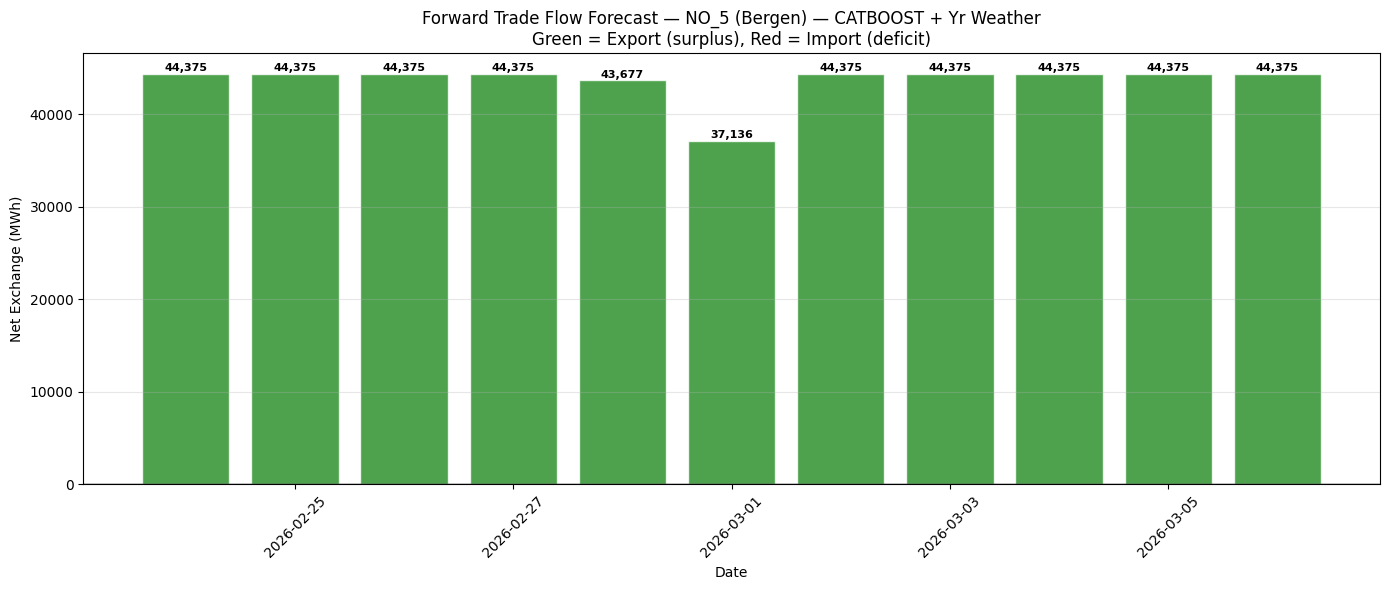


Forecast summary (11 days):
  Export days: 11 (100%)
  Import days: 0 (0%)
  Mean daily exchange: 43,653 MWh
  Total net exchange:  480,187 MWh
  Overall direction: NET EXPORT


In [15]:
from src.data.fetch_yr_forecast import fetch_yr_forecast

# Fetch Yr weather forecast for Bergen (NO_5)
yr_df = fetch_yr_forecast(ZONE, cache=True)

if not yr_df.empty:
    print(f"Yr forecast for {ZONE}: {len(yr_df)} hours")
    print(f"  Range: {yr_df.index.min()} to {yr_df.index.max()}")

    # Build forward feature matrix inline
    # Use last 336 hours (2 weeks) of history as template for non-weather features
    last_features = df.iloc[-336:]
    best_ml_model = {"xgboost": xgb_model, "lightgbm": lgbm_model, "catboost": cat_model}[
        min(model_maes, key=model_maes.get)
    ]

    # forecast_with_yr returns price forecasts — we need to adapt for trade flow
    # Build feature matrix manually for the forward forecast
    import holidays as holidays_lib

    forecast_index = yr_df.index
    n_steps = len(forecast_index)
    feature_cols = best_ml_model.feature_names_

    # Template: tile last known values
    template = last_features[feature_cols].iloc[-1:].copy()
    X_future = pd.DataFrame(
        np.tile(template.values, (n_steps, 1)),
        columns=feature_cols,
        index=forecast_index,
    )

    # Override calendar features
    no_hol = holidays_lib.Norway()
    cal_map = {
        "hour_of_day": forecast_index.hour,
        "day_of_week": forecast_index.dayofweek,
        "month": forecast_index.month,
        "week_of_year": forecast_index.isocalendar().week.values,
        "is_weekend": (forecast_index.dayofweek >= 5).astype(int),
        "is_holiday": pd.Series(
            [int(d in no_hol) for d in forecast_index.date],
            index=forecast_index,
        ),
        "is_business_hour": (
            (forecast_index.hour >= 8)
            & (forecast_index.hour <= 17)
            & (forecast_index.dayofweek < 5)
        ).astype(int),
    }
    for col, values in cal_map.items():
        if col in X_future.columns:
            X_future[col] = values

    # Override weather features with Yr forecast
    yr_to_hist = {
        "yr_temperature": "temperature",
        "yr_wind_speed": "wind_speed",
        "yr_precipitation_1h": "precipitation",
        "yr_cloud_cover": "cloud_cover",
        "yr_humidity": "humidity",
        "yr_pressure": "pressure",
    }
    for yr_col, hist_col in yr_to_hist.items():
        if hist_col in X_future.columns and yr_col in yr_df.columns:
            aligned = yr_df[yr_col].reindex(forecast_index)
            X_future[hist_col] = aligned

    # Predict trade flows
    forward_pred = best_ml_model.predict(X_future)

    # Aggregate to daily
    forward_daily = forward_pred.resample("D").mean().dropna()

    print(f"\nForward forecast: {len(forward_pred)} hours, {len(forward_daily)} days")
    print(f"  Hourly: mean={forward_pred.mean():,.0f} MWh, "
          f"min={forward_pred.min():,.0f}, max={forward_pred.max():,.0f}")

    # Daily bar chart: green = export, red = import
    fig, ax = plt.subplots(figsize=(14, 6))
    bar_colors = ["forestgreen" if v > 0 else "indianred" for v in forward_daily.values]
    bars = ax.bar(forward_daily.index, forward_daily.values,
                  width=0.8, color=bar_colors, alpha=0.8, edgecolor="white")

    # Add value labels
    for bar, val in zip(bars, forward_daily.values):
        y_pos = val + (50 if val > 0 else -50)
        va = "bottom" if val > 0 else "top"
        ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                f"{val:,.0f}", ha="center", va=va, fontsize=8, fontweight="bold")

    ax.axhline(y=0, color="black", linewidth=1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Net Exchange (MWh)")
    ax.set_title(f"Forward Trade Flow Forecast — {ZONE} (Bergen) — "
                 f"{min(model_maes, key=model_maes.get).upper()} + Yr Weather\n"
                 f"Green = Export (surplus), Red = Import (deficit)")
    ax.grid(True, alpha=0.3, axis="y")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Summary table
    n_export_days = (forward_daily > 0).sum()
    n_import_days = (forward_daily < 0).sum()
    print(f"\nForecast summary ({len(forward_daily)} days):")
    print(f"  Export days: {n_export_days} ({n_export_days/len(forward_daily)*100:.0f}%)")
    print(f"  Import days: {n_import_days} ({n_import_days/len(forward_daily)*100:.0f}%)")
    print(f"  Mean daily exchange: {forward_daily.mean():,.0f} MWh")
    print(f"  Total net exchange:  {forward_daily.sum():,.0f} MWh")
    if forward_daily.mean() > 0:
        print(f"  Overall direction: NET EXPORT")
    else:
        print(f"  Overall direction: NET IMPORT")
else:
    forward_pred = pd.Series(dtype=float)
    forward_daily = pd.Series(dtype=float)
    print("Yr forecast fetch failed — check network connection.")
    print("Forward trade flow forecast skipped.")

## 8. Key Findings

In [16]:
# Final summary
print("=" * 80)
print(f"TRADE FLOW FORECASTING SUMMARY — {ZONE} (Bergen)")
print("=" * 80)

print(f"\nTarget: {TARGET_COL} (daily net exchange, forward-filled to hourly)")
print(f"Validation period: {y_val.index.min().date()} to {y_val.index.max().date()}")
print(f"Features used: {X_train_full.shape[1]} (with leakage prevention: dropped {LEAKAGE_COLS})")

print(f"\n--- Model Performance ---")
display(comp)

best_method = comp.iloc[0]['Method']
best_mae = comp.iloc[0]['mae']
naive_mae = naive_metrics['mae']

print(f"\nBest model: {best_method} (MAE={best_mae:,.1f} MWh)")
if best_mae < naive_mae:
    print(f"  vs Naive ({naive_mae:,.1f} MWh): {(1-best_mae/naive_mae)*100:.1f}% improvement")
else:
    print(f"  vs Naive ({naive_mae:,.1f} MWh): did not beat baseline")

print(f"\n--- Top Features (SHAP) ---")
for i, (feat, val) in enumerate(mean_abs_shap.head(5).items(), 1):
    print(f"  {i}. {feat} (mean |SHAP|: {val:,.1f} MWh)")

print(f"\n--- Trade Flow Patterns ---")
print(f"  Validation export hours: {((y_val>0).mean()*100):.0f}%")
print(f"  Validation import hours: {((y_val<0).mean()*100):.0f}%")
print(f"  Mean net exchange: {y_val.mean():,.0f} MWh")
if "price_eur_mwh" in df.columns:
    trade_price_corr = df[TARGET_COL].corr(df["price_eur_mwh"])
    print(f"  Correlation with price: r={trade_price_corr:.3f}")
    if trade_price_corr < 0:
        print(f"    (Negative: exports increase when prices are low = surplus supply)")
    else:
        print(f"    (Positive: exports increase with higher prices)")

print(f"\n--- Walk-Forward Validation ({best_model_type}) ---")
print(f"  {len(wf_results)} folds, MAE: {np.mean(mae_values):,.0f} +/- {np.std(mae_values):,.0f} MWh")

if not forward_daily.empty:
    print(f"\n--- Forward Forecast ---")
    print(f"  Horizon: {len(forward_daily)} days ({forward_pred.index.min().date()} to {forward_pred.index.max().date()})")
    print(f"  Mean daily exchange: {forward_daily.mean():,.0f} MWh")
    direction = "NET EXPORT" if forward_daily.mean() > 0 else "NET IMPORT"
    print(f"  Overall direction: {direction}")

print(f"\n--- Seasonal Drivers ---")
# Monthly pattern from full dataset
monthly_mean = target.groupby(target.index.month).mean()
export_months = monthly_mean[monthly_mean > 0]
import_months = monthly_mean[monthly_mean < 0]
if len(export_months) > 0:
    print(f"  Typical export months: {', '.join([str(m) for m in export_months.index])}")
if len(import_months) > 0:
    print(f"  Typical import months: {', '.join([str(m) for m in import_months.index])}")

print("\n" + "-" * 80)
print("Observations:")
print("-" * 80)
print("1. Trade flows reflect the aggregate Norwegian supply-demand balance.")
print("   Production and consumption are the primary drivers.")
print("2. NO_5 has aggregate net exchange only (no per-cable breakdown).")
print("   Per-cable analysis requires NO_2 data (NorNed, NordLink, Skagerrak, NSL).")
print("3. Seasonal patterns: Norway typically exports in summer (hydro surplus)")
print("   and imports in winter (high heating demand).")
print("4. The daily resolution (forward-filled to hourly) limits within-day")
print("   prediction granularity. Hourly cable data would improve this.")
print("5. Trade flow direction is a useful regime indicator for price forecasting:")
print("   net import periods tend to coincide with higher, more volatile prices.")
print("")
print("Next steps:")
print("- Analyze per-cable flows for NO_2 (Phase 6: Cable Arbitrage)")
print("- Use trade flow forecast as input feature for price forecasting")
print("- Multi-target VAR integration (09f) to capture cross-target dependencies")

TRADE FLOW FORECASTING SUMMARY — NO_5 (Bergen)

Target: net_exchange_mwh (daily net exchange, forward-filled to hourly)
Validation period: 2025-01-01 to 2025-06-30
Features used: 35 (with leakage prevention: dropped ['net_balance_mwh'])

--- Model Performance ---


,Method,mae,rmse,mape,directional_accuracy,peak_hour_mae,fit_time_s,skill_score
Rank,,,,,,,,
1,CatBoost,31830.790,37892.805,86.08,1.0,31724.857,0.2,0.161
2,Ensemble (weighted),32741.111,38964.555,84.82,0.9,32758.804,0.0,0.138
3,LightGBM,33307.468,39446.273,83.92,0.5,33341.762,0.6,0.123
4,XGBoost,33767.930,39982.640,85.61,0.1,33769.085,0.1,0.110
5,Naive (same hour last week),37961.362,48125.333,154.61,2.1,37956.721,0.0,NaN



Best model: CatBoost (MAE=31,830.8 MWh)
  vs Naive (37,961.4 MWh): 16.1% improvement

--- Top Features (SHAP) ---
  1. generation_hydro (mean |SHAP|: 2,902.0 MWh)
  2. reservoir_vs_median (mean |SHAP|: 278.6 MWh)
  3. consumption_mwh (mean |SHAP|: 264.7 MWh)
  4. ng_fut_close (mean |SHAP|: 234.2 MWh)
  5. day_of_week (mean |SHAP|: 233.7 MWh)

--- Trade Flow Patterns ---
  Validation export hours: 97%
  Validation import hours: 3%
  Mean net exchange: 69,110 MWh
  Correlation with price: r=-0.278
    (Negative: exports increase when prices are low = surplus supply)

--- Walk-Forward Validation (catboost) ---
  6 folds, MAE: 23,495 +/- 11,025 MWh

--- Forward Forecast ---
  Horizon: 11 days (2026-02-24 to 2026-03-06)
  Mean daily exchange: 43,653 MWh
  Overall direction: NET EXPORT

--- Seasonal Drivers ---
  Typical export months: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

--------------------------------------------------------------------------------
Observations:
-----------------------